# Comparaison des prévisions de séries chronologiques de décès liés à la COVID-19

#### Importer les bibliothèques suivantes: 
- pmdarima, statsmodels, pandas, numpy, datetime, requests, matplotlib, warnings


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import metrics
from pmdarima.arima import auto_arima
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Tâche 1 : Charger les données dans un dataframe

In [2]:
df_raw = pd.read_csv('time_series_covid19_deaths_global.csv')
df_raw

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,1307,1312,1312,1328,1344,1354,1363,1363,1370,1375
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,189,193,199,200,205,208,213,219,225,228
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,1282,1293,1302,1312,1322,1333,1341,1351,1360,1370
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,52,52,52,52,52,53,53,53,53,53
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,67,70,75,78,80,80,80,86,86,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,94,96,97,100,104,105,106,106,108,110
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,512,512,515,518,523,528,528,528,528,530
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,200,203,235,241,241,246,246,256,260,260


Tout d’abord, récupérez les données sur les décès quotidiens dans tous les pays

In [3]:
grouped = df_raw.groupby('Country/Region').agg('sum', numeric_only = True)
grouped.drop(['Lat', 'Long'], axis = 1, inplace = True)

Transposez le dataframe

In [4]:
grouped.transpose()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8/12/20,1354,208,1333,53,80,3,5213,806,361,724,...,41414,37,211,247,18,105,1,528,246,122
8/13/20,1363,213,1341,53,80,3,5362,809,375,725,...,41432,37,216,259,21,106,1,528,246,128
8/14/20,1363,219,1351,53,86,3,5527,814,379,725,...,41443,38,220,266,22,106,1,528,256,128
8/15/20,1370,225,1360,53,86,3,5637,817,396,728,...,41446,38,225,276,24,108,1,528,260,130


Ensuite, additionnez les lignes

In [5]:
grouped = grouped.agg('sum').astype('int').reset_index()
grouped

,index,0
0,1/22/20,17
1,1/23/20,18
2,1/24/20,26
3,1/25/20,42
4,1/26/20,56
...,...,...
203,8/12/20,743989
204,8/13/20,750230
205,8/14/20,760374
206,8/15/20,765718


Créez un nouveau dataframe avec deux colonnes, qui sera notre jeu de données (dataset) 

In [6]:
df = grouped.copy().rename(columns = {'index' : 'Date', 0 : 'Deaths'})
df

,Date,Deaths
0,1/22/20,17
1,1/23/20,18
2,1/24/20,26
3,1/25/20,42
4,1/26/20,56
...,...,...
203,8/12/20,743989
204,8/13/20,750230
205,8/14/20,760374
206,8/15/20,765718



Obtenez les dates à partir des colonnes du bloc de données  `deaths_df`, à partir de la cinquième colonne. Ils seront obtenus sous forme de chaîne.

In [7]:
liste_dates = df_raw.columns[5:].to_list()
liste_dates

['1/23/20',
 '1/24/20',
 '1/25/20',
 '1/26/20',
 '1/27/20',
 '1/28/20',
 '1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5/20',
 '4/6/20',
 '4/7/20',
 '4/8/20',
 '4/9/20',
 '4/10/20',
 '4/11/20',
 '4/12/20',
 '4/13/20',
 '4/14/20',
 '4/15/20',
 '4/16/20',
 '4/17/

Convertissez les dates de chaîne au format datetime, afin que nous puissions effectuer des opérations  sur celles-ci
Maintenant, affectez les données de dates et de décès aux colonnes de la nouvelle trame de données :

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Deaths
0,2020-01-22,17
1,2020-01-23,18
2,2020-01-24,26
3,2020-01-25,42
4,2020-01-26,56
...,...,...
203,2020-08-12,743989
204,2020-08-13,750230
205,2020-08-14,760374
206,2020-08-15,765718


Nous n’aurons besoin que d'une seule colonne de données, y, l’index étant ds

In [9]:
df = df.set_index('Date')

Traçons le nombre quotidien de décès

<AxesSubplot: xlabel='Date'>

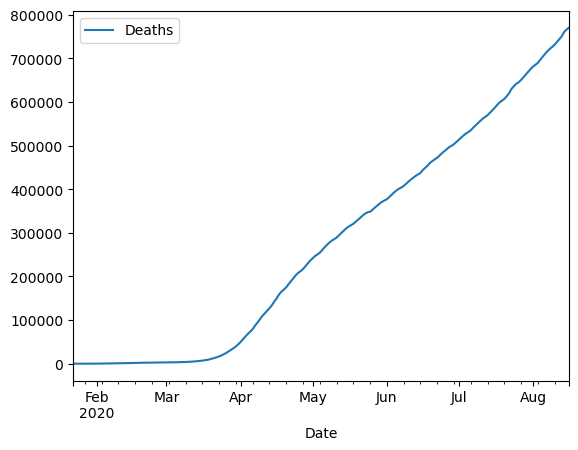

In [10]:
df.plot()

Voyons à quoi ressemble l’augmentation quotidienne. Pour ce faire, nous utiliserons la méthode `diff` de l’objet Dataframe.

<AxesSubplot: xlabel='Date'>

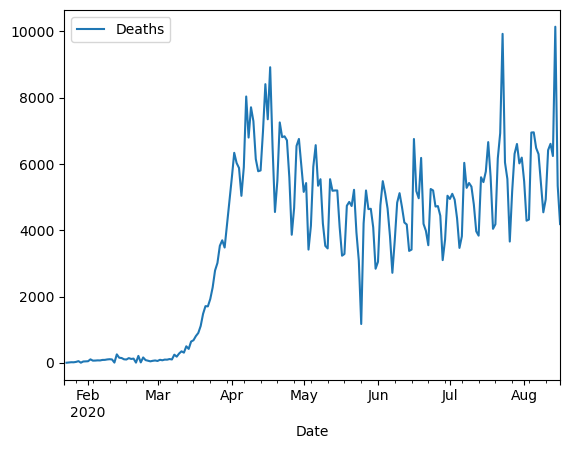

In [11]:
df.diff().plot()

Dans ce projet, nous allons analyser les décès quotidiens signalés

In [12]:
df = df.diff()
df

,Deaths
Date,
2020-01-22,NaN
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
...,...
2020-08-12,6609.0
2020-08-13,6241.0
2020-08-14,10144.0


Nous devons supprimer le premier point de données ici, qui sera une valeur None

In [13]:
df = df.tail(-1)
df

,Deaths
Date,
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
2020-01-27,26.0
...,...
2020-08-12,6609.0
2020-08-13,6241.0
2020-08-14,10144.0


# Tâche 2 : Forcasting à l’aide de SARIMAX, ou Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

#### Définissez SARIMAX ainsi que ses différents paramètres

---

Un modèle ARIMAX(p,d,q) correspond à une moyenne mobile autorégressive avec des variables exogènes. Cette méthode se compose des termes suivants :


![image](Equation.png)

- Le terme autorégressif (p) : C'est le nombre de valeurs que nous regardons dans le passé.
- La moyenne mobile (q) : Un processus de moyenne mobile est la combinaison linéaire des q derniers termes d'erreur et des termes d'erreur actuels, où q est l'ordre du processus.
- Variable X : Il s'agit de données qui sont des variables exogènes. Par exemple, si les données de la série temporelle concernent les ventes, il peut s'agir du code postal d'un magasin.
- c : Il s'agit d'un terme constant de base
- β,φ,θ : Il s'agit des estimations des coefficients qui proviennent du modèle.
- wt : Il s'agit du terme de bruit blanc qui suit une distribution normale et qui a une moyenne égale à zéro et une variance σ2 w

Un modèle SARIMAX(p,d,q)(P,D,Q)[m] prend en compte la saisonnalité. Cette méthode rajoute les termes suivants au modèle ARIMAX :

- P : Ordre autorégressif saisonnier
- D : Ordre de différence saisonnière
- Q : ordre de moyenne mobile saisonnière
- m : Le nombre de pas de temps pour une seule période saisonnière.

---

Avant d’appliquer chaque modèle, nous allons diviser notre ensemble de données en un ensemble de formation et de test. Pour ce faire, nous prendrons toutes les dates antérieures au 31 juillet comme ensemble de formation, sur lequel le modèle sera optimisé, et toutes les dates du 31 juillet comme ensemble de test, sur lequel nous testerons la précision des prédictions que le modèle optimisé fera.

In [14]:
date  = datetime(2020, 7, 31)

train = df[(df.index <  date)]
test = df[(df.index >= date)]

Parlons maintenant de SARIMAX. Il y a trois hyperparamètres qui entrent dans l’ordre tuple : p, q et d. Ici, nous avons utilisé p = 2, q = 1 et d = 3.


In [15]:
SARIMAX_model = SARIMAX(train, order=(2,1,3))

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Ensuite, nous appelons la méthode d’ajustement pour optimiser le modèle.

In [16]:
results = SARIMAX_model.fit(disp=True)

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Faisons maintenant des prédictions à l’aide du modèle et comparons-les aux valeurs de l’ensemble de tests.

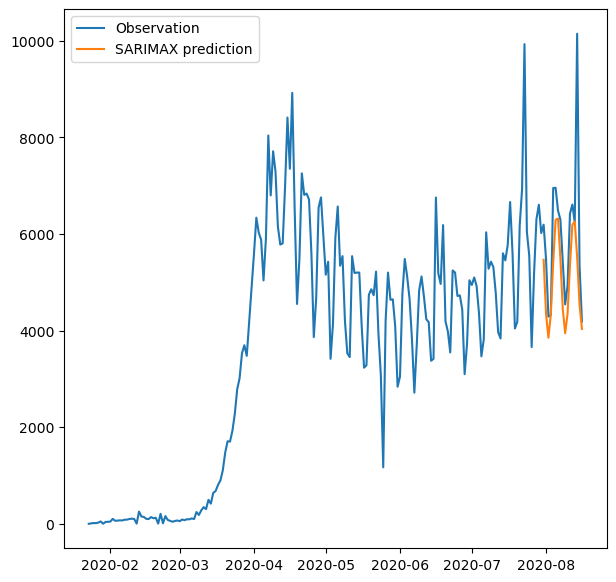

In [17]:
last_date = datetime(df.tail(1).index.year[0], df.tail(1).index.month[0], df.tail(1).index.day[0])

SARIMAX_pred = results.predict(start = date, end = last_date, dynamic=False)

plt.figure(figsize=(7, 7))

l1, = plt.plot(df, label = 'Observation')
l2, = plt.plot(SARIMAX_pred, label = 'SARIMAX prediction')

plt.legend(handles=[l1, l2])


Puisque nous sommes intéressés par la comparaison entre les différentes approches d’analyse de séries chronologiques, nous allons utiliser l’une des mesures de validation: erreur absolue moyenne


In [18]:
print(f'Erreur absolue moyenne : {metrics.mean_absolute_error(test, SARIMAX_pred)}')

Erreur absolue moyenne : 864.360922608651


#### Cependant, dans un flux de travail d’apprentissage automatique typique, nous devrions trouver les meilleures valeurs de p, q et r qui minimiseront l’erreur.
#### Définissez et écrire la fonction auto_arima du module pmdarima permettant de trouver la combinaison de paramètres optimale et de renvoyer le meilleur modèle.


In [19]:
model = auto_arima(train, 
                   seasonal = True,  
                   trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3040.433, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3132.320, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3133.730, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3133.267, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3130.535, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3106.295, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3099.421, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3043.877, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3025.720, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3105.847, Time=0.20 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3033.077, Time=0.32 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3039.079, Time=0.32 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3037.364, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0]             : 

# Tâche 3 : Prévision à l'aide du modèle Prophet de Facebook.

Définissez le modèle prophet de Facebook et importons les bibliothèques nécessaires

---

Prophet est une procédure de prévision des données de séries temporelles basée sur un modèle additif où les tendances non linéaires sont adaptées à la saisonnalité annuelle, hebdomadaire et quotidienne, ainsi qu'aux effets des vacances. Il fonctionne mieux avec les séries temporelles qui ont de forts effets saisonniers et plusieurs saisons de données historiques. Prophet est robuste aux données manquantes et aux changements de tendance, et gère généralement bien les valeurs aberrantes.

---

Ensuite, nous créons un nouvel objet Prophet et appelons la méthode `fit()`.

In [20]:
PROPHET_model = Prophet(interval_width = 0.97)

date  = datetime(2020, 7, 31)

df_prophet = df.reset_index().rename(columns = {'Date' : 'ds', 'Deaths' : 'y'})

prophet_train = df_prophet[(df_prophet['ds'] <  date)]
prophet_test = df_prophet[(df_prophet['ds'] >= date)]

results = PROPHET_model.fit(prophet_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\ProgramData\Anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Maintenant, faisons des prévisions :

In [21]:
PROPHET_pred = PROPHET_model.predict(prophet_test)

c:\ProgramData\Anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\ProgramData\Anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Calculons maintenant l'erreur absolue moyenne pour nos prédictions.

In [22]:
print(f"Erreur absolue moyenne : {metrics.mean_absolute_error(prophet_test['y'], PROPHET_pred['yhat'])}")

Erreur absolue moyenne : 759.1275835131203


Ensuite, visualisons les prédictions.

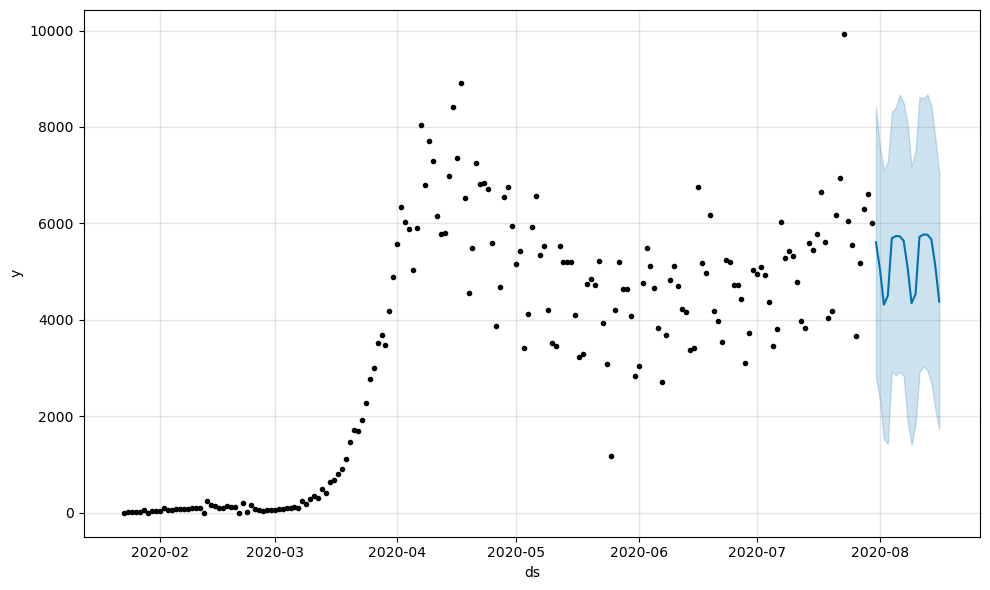

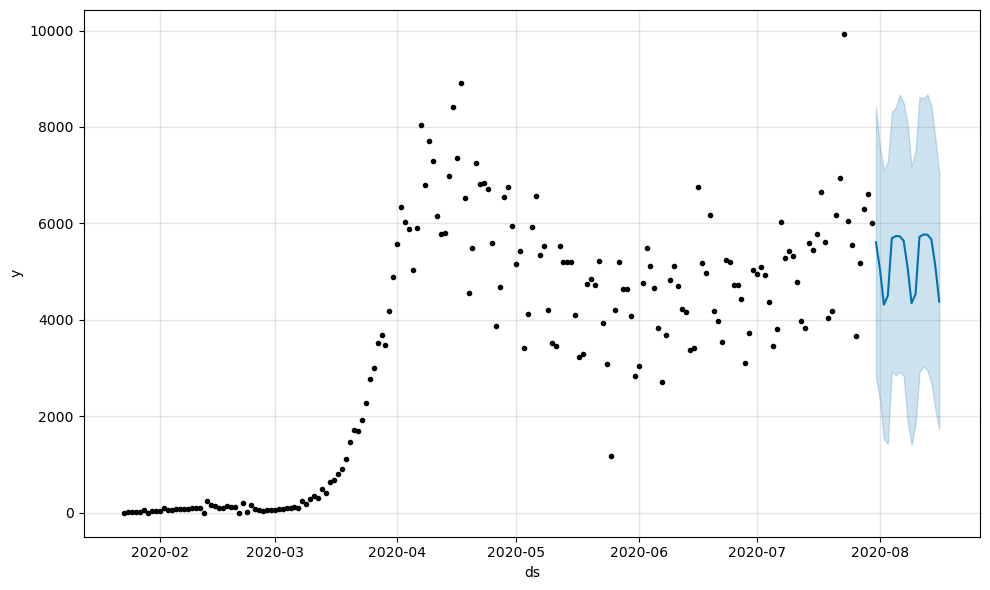

In [23]:
PROPHET_model.plot(PROPHET_pred, uncertainty=True)

# Tâche 4 : Préparation du jeu de données pour XGBOOST 

Définisseons XGBOOST et NN et importons les bibliothèques nécessaires

---

Le Boosting de Gradient est un algorithme d’apprentissage supervisé dont le principe et de combiner les résultats d’un ensemble de modèles plus simple et plus faibles afin de fournir une meilleur prédiction.

Un Neural Network est un ensemble de neurones formels interconnectés permettant la résolution de problèmes complexes tels que la reconnaissance des formes ou le traitement du langage naturel, grâce à l'ajustement des coefficients de pondération dans une phase d'apprentissage.

---

### Créez des ensembles de données de training et de test en divisant l'ensemble de données, et effectuez la normalisation des données.


Dans cette tâche, nous allons aborder deux sujets relatifs à la préparation des données : la division de l'ensemble de données en données de formation et de test, et la normalisation des données.

Vous avez peut-être déjà effectué une opération de division d'un ensemble de données dans le cadre de l'apprentissage automatique, où l'on prend une partie de l'ensemble de données choisie au hasard, disons 20 %, comme ensemble de test, tandis que les 80 % restants constituent l'ensemble de formation. Cette sélection est aléatoire car l'ensemble des données est mélangé de manière aléatoire avant la sélection. Une autre approche populaire est la validation croisée k-fold.

- Définissez ces deux méthodes
- Est- ce que ces deux méthodes fonctionnent avec les séries temporelles? Justifier la réponse 



---

L'approche Train-Test Split consiste à décomposer de manière aléatoire un ensemble de données. Une partie servira à l'entraînement du modèle de Machine Learning, l'autre partie permettra de le tester pour la validation.

La validation croisée k-fold signifie que l’ensemble de données se divise en un nombre K. Elle divise l’ensemble de données au point où l’ensemble de test utilise chaque pli.

Ces méthodes ne peuvent pas marcher pour les séries temporelles car leur prédiction se base sur la continuité des données jusqu'à un certain point ou l'on veut les prédir. Il ne faut donc surtout pas mélanger les données.

---

Parlons maintenant de la normalisation des données. Nous effectuons la normalisation des données de manière à rendre la plage de valeurs des caractéristiques, ou des colonnes de la table X_train, aussi proche que possible. Par exemple, nous avons les caractéristiques dayofweek et dayofyear. La plage de valeurs de dayofweek va de 1 à 7, tandis que dayofyear va de 1 à 365. Des différences aussi importantes dans les plages de valeurs vont soit ralentir la formation du modèle d'apprentissage automatique, soit la rendre très difficile. Nous résolvons ce problème en appliquant la normalisation. Il existe plusieurs façons de normaliser les données. Ici, je vais choisir le StandardScaler, qui applique l'équation suivante sur chacune des colonnes.

z = (x - u) / s

Ici, x est la colonne avant la mise à l'échelle, u est la moyenne et s est l'écart-type. En gros, nous soustrayons la moyenne de chaque colonne à elle-même, puis nous divisons par l'écart type de cette colonne. 

Pour appliquer StandardScaler, nous adaptons d'abord l'objet de mise à l'échelle à l'ensemble de données :

In [24]:
def featurize(original):
    X = pd.DataFrame()

    X['day'] = original.index.day
    X['month'] = original.index.month
    X['year'] = original.index.year
    X.index = original.index
    X['Deaths'] = original['Deaths']
            
    y = original['Deaths']
    return X, y

X_train, y_train = featurize(
    df.loc[df.index <  date])
X_test, y_test = featurize(
    df.loc[df.index >= date])

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

Appliquez la mise à l'échelle aux ensembles de formation et de test, comme suit.

In [25]:
scaled_train = scaler.transform(X_train)
scaled_test  = scaler.transform(X_test)

# Tâche 5 : Entraîner les modèles XGBOOST et NN

Tout d'abord, créez l'objet XGBRegressor qui représentera le modèle de régression XGBOOST.


In [26]:
XGBOOST_model = XGBRegressor(n_estimators = 100)

Ensuite, entraînez le modèle de régression XGBOOST en utilisant la méthode fit, et effectuez la prédiction en utilisant la méthode predict.

In [27]:
XGBOOST_model.fit(scaled_train, y_train, eval_set=[(scaled_train, y_train), (scaled_test, y_test)], verbose=True)

XGBOOST_pred = XGBOOST_model.predict(scaled_test)

[0]	validation_0-rmse:3087.87756	validation_1-rmse:4457.18245
[1]	validation_0-rmse:2205.81376	validation_1-rmse:3252.28496
[2]	validation_0-rmse:1581.49022	validation_1-rmse:2391.09564
[3]	validation_0-rmse:1142.14383	validation_1-rmse:1813.25416
[4]	validation_0-rmse:828.40040	validation_1-rmse:1405.79795
[5]	validation_0-rmse:605.12996	validation_1-rmse:1108.20085
[6]	validation_0-rmse:446.78612	validation_1-rmse:887.17523
[7]	validation_0-rmse:334.62090	validation_1-rmse:720.92697
[8]	validation_0-rmse:255.77599	validation_1-rmse:603.42175
[9]	validation_0-rmse:199.18861	validation_1-rmse:510.39420
[10]	validation_0-rmse:157.25503	validation_1-rmse:437.65306
[11]	validation_0-rmse:126.86852	validation_1-rmse:383.54795
[12]	validation_0-rmse:103.79318	validation_1-rmse:335.81778
[13]	validation_0-rmse:86.32298	validation_1-rmse:297.05349
[14]	validation_0-rmse:72.69850	validation_1-rmse:264.14996
[15]	validation_0-rmse:61.17884	validation_1-rmse:237.23116
[16]	validation_0-rmse:52.4

Calculons l'erreur absolue moyenne (MAE)

In [28]:
print(f"Erreur absolue moyenne : {metrics.mean_absolute_error(XGBOOST_pred, y_test)}")

Erreur absolue moyenne : 73.89978745404412


Création et formation du modèle de réseau de neurones (NN) à action directe.

In [29]:
NN_model = Sequential()
NN_model.add(Dense(20, input_shape=(scaled_train.shape[1], )))
NN_model.add(Dense(10))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.001))
NN_model.fit(scaled_train, y_train, validation_data=(
    scaled_test, y_test), epochs=300, verbose=1)
NN_pred = NN_model.predict(scaled_test)

Epoch 1/300


C:\Users\antoine.lecroart\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


6/6 [==============================] - 0s 21ms/step - loss: 3521.5283 - val_loss: 5930.0161
Epoch 2/300
6/6 [==============================] - 0s 4ms/step - loss: 3521.4751 - val_loss: 5929.9224
Epoch 3/300
6/6 [==============================] - 0s 4ms/step - loss: 3521.4207 - val_loss: 5929.8594
Epoch 4/300
6/6 [==============================] - 0s 4ms/step - loss: 3521.3665 - val_loss: 5929.7861
Epoch 5/300
6/6 [==============================] - 0s 4ms/step - loss: 3521.3088 - val_loss: 5929.6938
Epoch 6/300
6/6 [==============================] - 0s 4ms/step - loss: 3521.2490 - val_loss: 5929.6543
Epoch 7/300
6/6 [==============================] - 0s 4ms/step - loss: 3521.1812 - val_loss: 5929.5537
Epoch 8/300
6/6 [==============================] - 0s 5ms/step - loss: 3521.1118 - val_loss: 5929.4526
Epoch 9/300
6/6 [==============================] - 0s 4ms/step - loss: 3521.0342 - val_loss: 5929.3403
Epoch 10/300
6/6 [==============================] - 0s 4ms/step - loss: 3520.9480 - 

Comparons les valeurs MAE.

In [30]:
print(f"Erreur absolue moyenne : {metrics.mean_absolute_error(NN_pred, y_test)}")

Erreur absolue moyenne : 0.9559685202205882


Enfin, visualisons les prédictions des 4 modèles.
Notez la méthode autofmt_xdate dans matplotlib, elle sait comment faire pivoter de manière appropriée les étiquettes de date sur l'axe des x.

In [31]:
PROPHET_df = test.copy()
PROPHET_df['Deaths'] = PROPHET_pred['yhat'].tolist()

In [32]:
XGBOOST_df = test.copy()
XGBOOST_df['Deaths'] = XGBOOST_pred

In [33]:
NN_df = test.copy()
NN_df['Deaths'] = NN_pred

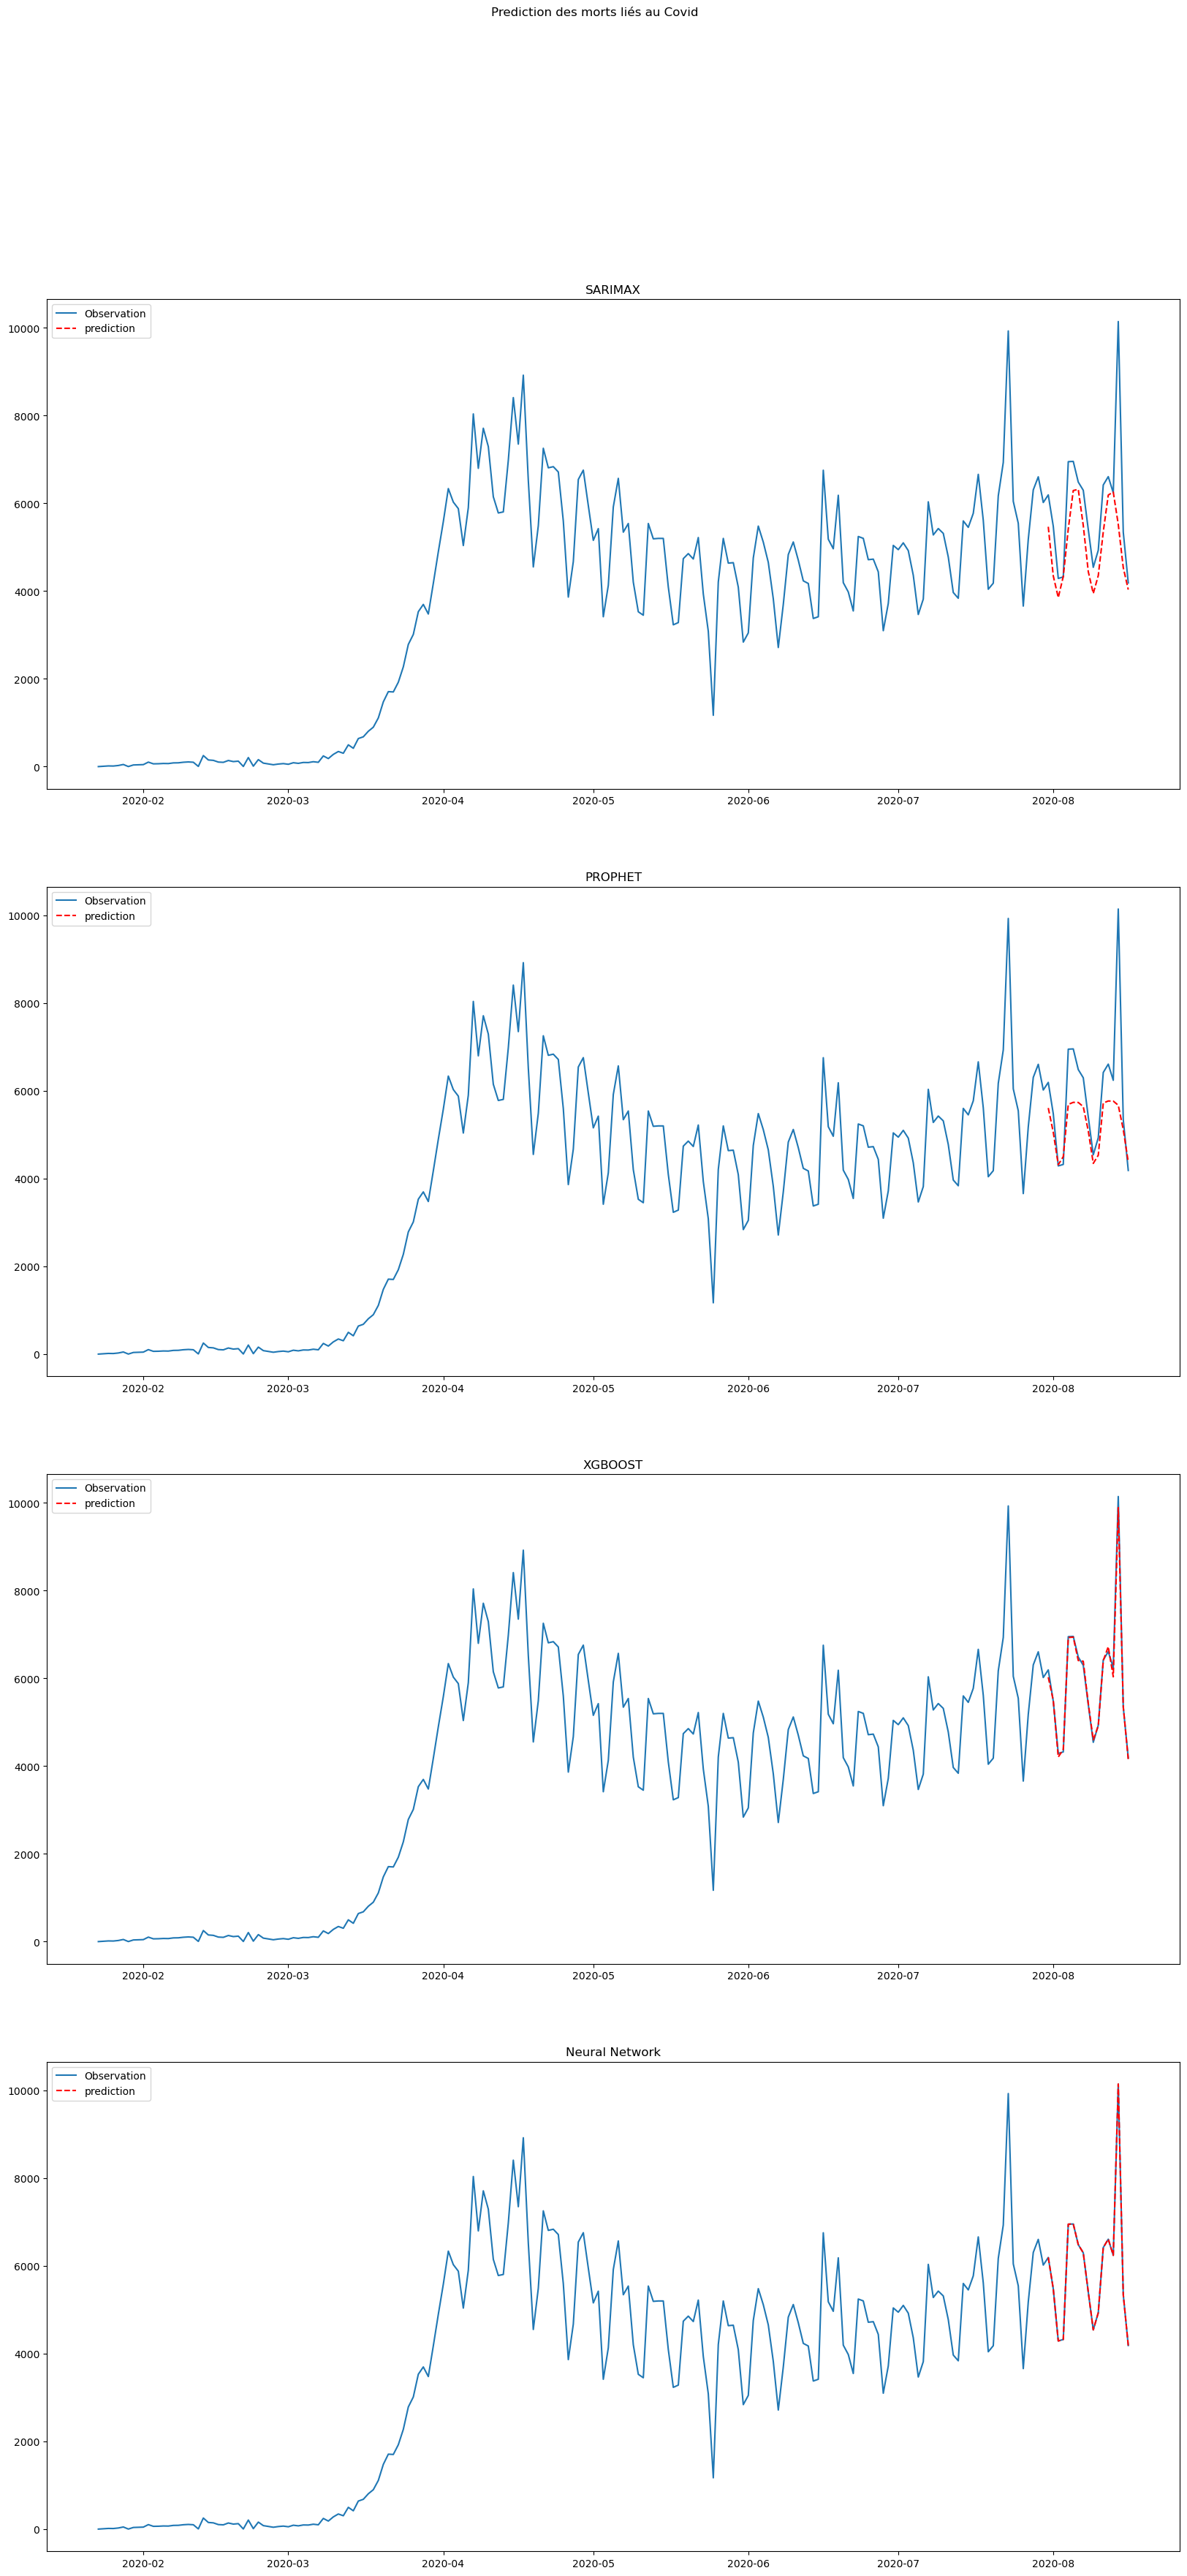

In [34]:
fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (20, 40))
fig.suptitle('Prediction des morts liés au Covid')


axes[0].plot(df, label = 'Observation')
axes[0].plot(SARIMAX_pred, label = 'prediction', linestyle = 'dashed', color = 'red')
axes[0].set_title('SARIMAX')
axes[0].legend()

axes[1].plot(df, label = 'Observation')
axes[1].plot(PROPHET_df, label = 'prediction', linestyle = 'dashed', color = 'red')
axes[1].set_title('PROPHET')
axes[1].legend()

axes[2].plot(df, label = 'Observation')
axes[2].plot(XGBOOST_df, label = 'prediction', linestyle = 'dashed', color = 'red')
axes[2].set_title('XGBOOST')
axes[2].legend()

axes[3].plot(df, label = 'Observation')
axes[3].plot(NN_df, label = 'prediction', linestyle = 'dashed', color = 'red')
axes[3].set_title('Neural Network')
axes[3].legend()
